<a href="https://colab.research.google.com/github/orlovaea/nlp_ha/blob/main/nlp_ha9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Домашнее задание № 9. Предобученные трансформеры 

### Задание 1 (8 баллов).
Дообучите 3 предобученных модели на тех же данных, что и в семинаре. Сравните качество и выберите лучшую. 
Модели должны отличаться друг от друга не только параметрами ru/en/multilingual, base/large, cased/uncased. Все три выбранные модели должны работать лучше, чем бейзлайн без дообучения (т.е. если модель не работает, попробуйте другую).




In [1]:
!pip3 install scikit-learn pandas matplotlib transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 47.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 45.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.1/200.1 KB 4.0 MB/s eta 0:00:00


In [2]:
import os, re
import numpy as np
from time import time
from sklearn.model_selection import train_test_split
import pandas as pd
from collections import Counter
from string import punctuation
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
%matplotlib inline

import tensorflow as tf
from transformers import TFAutoModel
from transformers import AutoTokenizer

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
data = pd.read_csv('/content/drive/MyDrive/lenta_sample.csv')
data.dropna(subset=['topic', 'text'], inplace=True)
data.shape

(607, 6)

#### cointegrated/LaBSE-en-ru

In [ ]:
tokenizer = AutoTokenizer.from_pretrained('cointegrated/LaBSE-en-ru')
model = TFAutoModel.from_pretrained('cointegrated/LaBSE-en-ru', trainable=True)

Some layers from the model checkpoint at cointegrated/LaBSE-en-ru were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at cointegrated/LaBSE-en-ru.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [ ]:
X = []

for text in data.title:
    ids = tokenizer.encode(text)
    
    X.append(ids[:512])

X = tf.keras.preprocessing.sequence.pad_sequences(X, padding='post', maxlen=512)

id2label = {i:label for i, label in enumerate(set(data.topic.values))}
label2id = {l:i for i, l in id2label.items()}

y = tf.keras.utils.to_categorical([label2id[label] for label in data.topic.values])

train_index, valid_index = train_test_split(list(range(len(X))), test_size=0.05, stratify=data.topic)

X_train, y_train = X[train_index], y[train_index]
X_valid, y_valid = X[valid_index], y[valid_index]

In [ ]:
input_word_ids = tf.keras.layers.Input(shape=(512,), dtype=tf.int32,
                                     name="input_ids")

output = model({"input_ids":input_word_ids})
drop = tf.keras.layers.Dropout(0.1)(output[0][:, 0]) 
dense = tf.keras.layers.Dense(y.shape[1], activation='softmax')(drop)

model_clf = tf.keras.Model(inputs=input_word_ids, outputs=dense)


model_clf.compile(tf.optimizers.Adam(learning_rate=2e-6,
                                    ), 
                  loss='categorical_crossentropy', 
                  metrics=['accuracy', 
                           tf.keras.metrics.RecallAtPrecision(0.80, name='rec_prec')])

In [ ]:
model_clf.fit(X_train, y_train, 
          validation_data=(X_valid, y_valid),
          batch_size=4,
          epochs=15)

Epoch 1/15


144/144 [==============================] - 122s 521ms/step - loss: 2.8533 - accuracy: 0.0833 - rec_prec: 0.0000e+00 - val_loss: 2.6212 - val_accuracy: 0.0968 - val_rec_prec: 0.0000e+00
Epoch 2/15
144/144 [==============================] - 70s 487ms/step - loss: 2.6851 - accuracy: 0.1233 - rec_prec: 0.0000e+00 - val_loss: 2.5031 - val_accuracy: 0.1935 - val_rec_prec: 0.0000e+00
Epoch 3/15
144/144 [==============================] - 70s 487ms/step - loss: 2.4856 - accuracy: 0.2292 - rec_prec: 0.0122 - val_loss: 2.1660 - val_accuracy: 0.3226 - val_rec_prec: 0.1290
Epoch 4/15
144/144 [==============================] - 70s 485ms/step - loss: 1.9369 - accuracy: 0.4062 - rec_prec: 0.1528 - val_loss: 1.8805 - val_accuracy: 0.3871 - val_rec_prec: 0.1935
Epoch 5/15
144/144 [==============================] - 70s 485ms/step - loss: 1.5837 - accuracy: 0.4948 - rec_prec: 0.2240 - val_loss: 1.7270 - val_accuracy: 0.4516 - val_rec_prec: 0.2903
Epoch 6/15
144/144 [==============================] - 70s 4

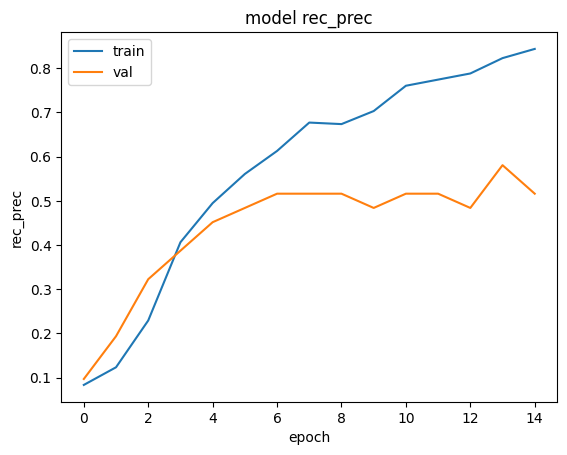

In [ ]:
plt.plot(model_clf.history.history['accuracy'])
plt.plot(model_clf.history.history['val_accuracy'])
plt.title('model rec_prec')
plt.ylabel('rec_prec')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
from sklearn.metrics import classification_report

pred = model_clf.predict(X_valid).argmax(1)

print(classification_report(y_valid.argmax(1), pred, labels=list(range(len(label2id))),
                            target_names=list(label2id), zero_division=0))

1/1 [==============================] - 6s 6s/step
                   precision    recall  f1-score   support

              Мир       0.50      1.00      0.67         1
Силовые структуры       0.67      1.00      0.80         2
      Бывший СССР       0.50      0.67      0.57         3
              Дом       0.67      1.00      0.80         2
          Легпром       0.00      0.00      0.00         1
         Из жизни       0.50      0.33      0.40         3
             Крым       0.00      0.00      0.00         0
         Культура       0.50      1.00      0.67         3
   Интернет и СМИ       0.00      0.00      0.00         2
         Ценности       1.00      0.50      0.67         2
       Библиотека       0.00      0.00      0.00         0
           Россия       0.00      0.00      0.00         2
           Бизнес       1.00      0.50      0.67         2
   69-я параллель       0.00      0.00      0.00         1
  Наука и техника       0.50      0.67      0.57         3
     

#### amberoad/bert-multilingual-passage-reranking-msmarco

In [ ]:
tokenizer = AutoTokenizer.from_pretrained('amberoad/bert-multilingual-passage-reranking-msmarco')
model = TFAutoModel.from_pretrained('amberoad/bert-multilingual-passage-reranking-msmarco', trainable=True)

Some layers from the model checkpoint at amberoad/bert-multilingual-passage-reranking-msmarco were not used when initializing TFBertModel: ['dropout_113', 'classifier']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at amberoad/bert-multilingual-passage-reranking-msmarco.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [ ]:
X = []

for text in data.title:
    ids = tokenizer.encode(text)
    
    X.append(ids[:512])

X = tf.keras.preprocessing.sequence.pad_sequences(X, padding='post', maxlen=512)

id2label = {i:label for i, label in enumerate(set(data.topic.values))}
label2id = {l:i for i, l in id2label.items()}

y = tf.keras.utils.to_categorical([label2id[label] for label in data.topic.values])

train_index, valid_index = train_test_split(list(range(len(X))), test_size=0.05, stratify=data.topic)

X_train, y_train = X[train_index], y[train_index]
X_valid, y_valid = X[valid_index], y[valid_index]

In [ ]:
input_word_ids = tf.keras.layers.Input(shape=(512,), dtype=tf.int32,
                                     name="input_ids")

output = model({"input_ids":input_word_ids})
drop = tf.keras.layers.Dropout(0.1)(output[0][:, 0]) 
dense = tf.keras.layers.Dense(y.shape[1], activation='softmax')(drop)

model_clf = tf.keras.Model(inputs=input_word_ids, outputs=dense)


model_clf.compile(tf.optimizers.Adam(learning_rate=2e-6,
                                    ), 
                  loss='categorical_crossentropy', 
                  metrics=['accuracy', 
                           tf.keras.metrics.RecallAtPrecision(0.80, name='rec_prec')])

In [ ]:
model_clf.fit(X_train, y_train, 
          validation_data=(X_valid, y_valid),
          batch_size=4,
          epochs=15)

Epoch 1/15


144/144 [==============================] - 117s 520ms/step - loss: 2.8586 - accuracy: 0.0694 - rec_prec: 0.0000e+00 - val_loss: 2.7486 - val_accuracy: 0.0645 - val_rec_prec: 0.0000e+00
Epoch 2/15
144/144 [==============================] - 70s 486ms/step - loss: 2.7974 - accuracy: 0.0764 - rec_prec: 0.0000e+00 - val_loss: 2.7040 - val_accuracy: 0.0968 - val_rec_prec: 0.0000e+00
Epoch 3/15
144/144 [==============================] - 71s 497ms/step - loss: 2.7591 - accuracy: 0.0799 - rec_prec: 0.0000e+00 - val_loss: 2.7270 - val_accuracy: 0.0645 - val_rec_prec: 0.0000e+00
Epoch 4/15
144/144 [==============================] - 73s 509ms/step - loss: 2.7651 - accuracy: 0.0799 - rec_prec: 0.0000e+00 - val_loss: 2.7055 - val_accuracy: 0.0968 - val_rec_prec: 0.0000e+00
Epoch 5/15
144/144 [==============================] - 73s 505ms/step - loss: 2.7651 - accuracy: 0.0747 - rec_prec: 0.0000e+00 - val_loss: 2.7118 - val_accuracy: 0.0968 - val_rec_prec: 0.0000e+00
Epoch 6/15
144/144 [===============

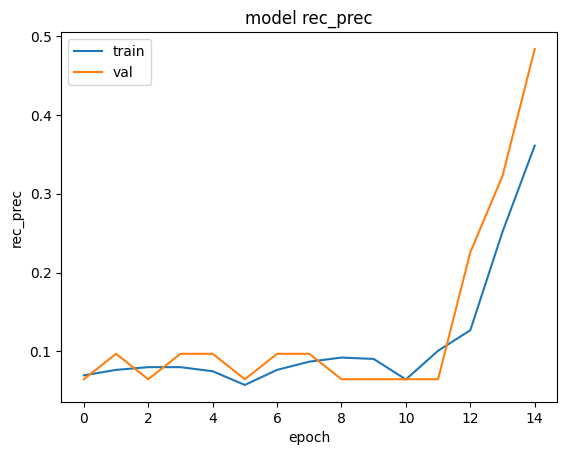

In [ ]:
plt.plot(model_clf.history.history['accuracy'])
plt.plot(model_clf.history.history['val_accuracy'])
plt.title('model rec_prec')
plt.ylabel('rec_prec')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
from sklearn.metrics import classification_report

pred = model_clf.predict(X_valid).argmax(1)

print(classification_report(y_valid.argmax(1), pred, labels=list(range(len(label2id))),
                            target_names=list(label2id), zero_division=0))

1/1 [==============================] - 4s 4s/step
                   precision    recall  f1-score   support

         Из жизни       0.75      1.00      0.86         3
  Наука и техника       1.00      0.67      0.80         3
           Россия       0.00      0.00      0.00         2
            Спорт       0.50      0.50      0.50         2
         Ценности       0.25      0.50      0.33         2
           Бизнес       0.20      0.50      0.29         2
   69-я параллель       0.00      0.00      0.00         1
         Культура       0.75      1.00      0.86         3
       Библиотека       0.00      0.00      0.00         0
          Легпром       0.00      0.00      0.00         1
        Экономика       0.00      0.00      0.00         2
              Дом       0.33      0.50      0.40         2
Силовые структуры       1.00      0.50      0.67         2
             Крым       0.00      0.00      0.00         0
      Бывший СССР       0.50      0.67      0.57         3
   Ин

#### blanchefort/rubert-base-cased-sentiment-rurewiews

In [25]:
tokenizer = AutoTokenizer.from_pretrained('blanchefort/rubert-base-cased-sentiment-rurewiews')
model = TFAutoModel.from_pretrained('blanchefort/rubert-base-cased-sentiment-rurewiews', trainable=True)

Some layers from the model checkpoint at blanchefort/rubert-base-cased-sentiment-rurewiews were not used when initializing TFBertModel: ['classifier', 'dropout_37']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at blanchefort/rubert-base-cased-sentiment-rurewiews.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [26]:
X = []

for text in data.title:
    ids = tokenizer.encode(text)
    
    X.append(ids[:512])

X = tf.keras.preprocessing.sequence.pad_sequences(X, padding='post', maxlen=512)

id2label = {i:label for i, label in enumerate(set(data.topic.values))}
label2id = {l:i for i, l in id2label.items()}

y = tf.keras.utils.to_categorical([label2id[label] for label in data.topic.values])

train_index, valid_index = train_test_split(list(range(len(X))), test_size=0.05, stratify=data.topic)

X_train, y_train = X[train_index], y[train_index]
X_valid, y_valid = X[valid_index], y[valid_index]

In [27]:
input_word_ids = tf.keras.layers.Input(shape=(512,), dtype=tf.int32,
                                     name="input_ids")

output = model({"input_ids":input_word_ids})
drop = tf.keras.layers.Dropout(0.1)(output[0][:, 0]) 
dense = tf.keras.layers.Dense(y.shape[1], activation='softmax')(drop)

model_clf = tf.keras.Model(inputs=input_word_ids, outputs=dense)


model_clf.compile(tf.optimizers.Adam(learning_rate=2e-6,
                                    ), 
                  loss='categorical_crossentropy', 
                  metrics=['accuracy', 
                           tf.keras.metrics.RecallAtPrecision(0.80, name='rec_prec')])

In [28]:
model_clf.fit(X_train, y_train, 
          validation_data=(X_valid, y_valid),
          batch_size=4,
          epochs=15)

Epoch 1/15


144/144 [==============================] - 132s 531ms/step - loss: 2.8484 - accuracy: 0.0642 - rec_prec: 0.0000e+00 - val_loss: 2.6249 - val_accuracy: 0.1935 - val_rec_prec: 0.0000e+00
Epoch 2/15
144/144 [==============================] - 73s 505ms/step - loss: 2.7576 - accuracy: 0.1042 - rec_prec: 0.0000e+00 - val_loss: 2.5830 - val_accuracy: 0.1935 - val_rec_prec: 0.0323
Epoch 3/15
144/144 [==============================] - 71s 496ms/step - loss: 2.6853 - accuracy: 0.1128 - rec_prec: 0.0017 - val_loss: 2.5587 - val_accuracy: 0.1935 - val_rec_prec: 0.0323
Epoch 4/15
144/144 [==============================] - 73s 506ms/step - loss: 2.5956 - accuracy: 0.1806 - rec_prec: 0.0104 - val_loss: 2.4239 - val_accuracy: 0.2581 - val_rec_prec: 0.0323
Epoch 5/15
144/144 [==============================] - 71s 496ms/step - loss: 2.3786 - accuracy: 0.2778 - rec_prec: 0.0191 - val_loss: 2.2117 - val_accuracy: 0.3226 - val_rec_prec: 0.0323
Epoch 6/15
144/144 [==============================] - 73s 507ms

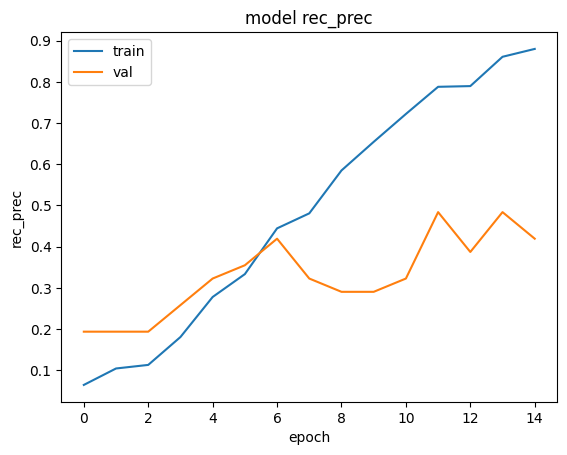

In [29]:
plt.plot(model_clf.history.history['accuracy'])
plt.plot(model_clf.history.history['val_accuracy'])
plt.title('model rec_prec')
plt.ylabel('rec_prec')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [30]:
from sklearn.metrics import classification_report

pred = model_clf.predict(X_valid).argmax(1)

print(classification_report(y_valid.argmax(1), pred, labels=list(range(len(label2id))),
                            target_names=list(label2id), zero_division=0))

1/1 [==============================] - 6s 6s/step
                   precision    recall  f1-score   support

          Легпром       0.00      0.00      0.00         1
         Ценности       0.67      1.00      0.80         2
         Культура       0.50      0.33      0.40         3
        Экономика       1.00      0.50      0.67         2
   69-я параллель       0.00      0.00      0.00         1
      Бывший СССР       0.20      0.33      0.25         3
             Крым       0.00      0.00      0.00         0
         Из жизни       0.00      0.00      0.00         3
           Россия       0.00      0.00      0.00         2
           Бизнес       0.40      1.00      0.57         2
       Библиотека       0.00      0.00      0.00         0
Силовые структуры       0.00      0.00      0.00         2
            Спорт       0.67      1.00      0.80         2
  Наука и техника       0.67      0.67      0.67         3
              Дом       0.33      0.50      0.40         2
   Ин

#### Summary

**LaBSE-en-ru:** accuracy на последней эпохе = 0.8438, f1 score (weighted avg) = 0.47

**bert-multilingual-passage-reranking-msmarco:** accuracy на последней эпохе = 0.3611, f1 score (weighted avg) = 0.44

**rubert-base-cased-sentiment-rurewiews:** accuracy на последней эпохе = 0.8802, f1 score (weighted avg) = 0.37

Лучший результат по f1-score среди трех моделей - у LaBSE-en-ru 

п.с. изначально пробовала модели xlm-roberta-base и bert-base-multilingual-cased, но у них все метрики были около 0..

### Задание  2 (2 балла)

Ответьте на следующие вопросы (напишите хотя бы по несколько предложений):

1) Чем ROBERTA отличается от BERT? В какой статье описана ROBERTA?

ROBERTA впервые была описана в статье "RoBERTa: A Robustly Optimized BERT Pretraining Approach" (https://arxiv.org/abs/1907.11692). Основные отличия от BERT: ROBERTA обучалась на бОльшем кол-ве данных (160gb)  с бОльшим числом батчей. Из-за этого увеличилось время обучения; в отличие от BERT, обучается только генерации пропущенного токена и не обучается предсказанию следующего предложения; динамическое маскирование токенов 

2) Чем модель T5 отличается от ROBERTA/BERT?

Модель T5 (encoder-decoder model) создана в первую очередь для генерации текста (text-to-text) и может применяться для решения широкого спектра задач (перевод, abstract summarization и др.). Это делает модель более гибкой по сравнению с ROBERTA/BERT (“encoder-only” models), которые могут использоваться для классификации и прогнозирования, но не для генерации текста. 